# Try using HDBSCAN to cluster things

Links:
* [HDBSCAN vs other clustering algorithms - an exploration](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html)
* [sklearn HDBSCAN docs](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html)

## Notes to self

do we need to normalize the data?
should try different distance metrics? euclidean, vs?

# TODO

* metrics: what fraction of hashes clustered; coherence (??) of clusters;
* downstream: which clusters in which samples?

In [1]:
from sourmash import sourmash_args
import numpy
import seaborn as sns
import sklearn.cluster
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.lines import Line2D

from hash_presence_lib import HashPresenceInformation


## Load presence information

In [2]:
presence_dump = 'agatha-genomes.1k.dump'
scaled=10000
min_presence_threshold=5

In [3]:
presence_info = HashPresenceInformation.load_from_file(presence_dump)
print(f"loaded {len(presence_info.hash_to_sample)} hash to sample entries.")

loaded 27398 hash to sample entries.


In [4]:
presence_info = presence_info.downsample(scaled)
print(f"downsampled to scaled={presence_info.scaled}; {len(presence_info.hash_to_sample)} hashes left.")

downsampled to scaled=10000; 2692 hashes left.


In [5]:
presence_info = presence_info.filter_by_min_samples(min_presence_threshold)
print(f"filtered to min_presence={min_presence_threshold}; {len(presence_info.hash_to_sample)} hashes left.")

filtered to min_presence=5; 608 hashes left.


## Cluster by hash association using `HDBSCAN`

In [6]:
assoc_hashvals, assoc_cmp = presence_info.build_association_matrix()
assert len(assoc_hashvals) == len(presence_info.hash_to_sample)

creating 608 by 608 array.


got 5 labels


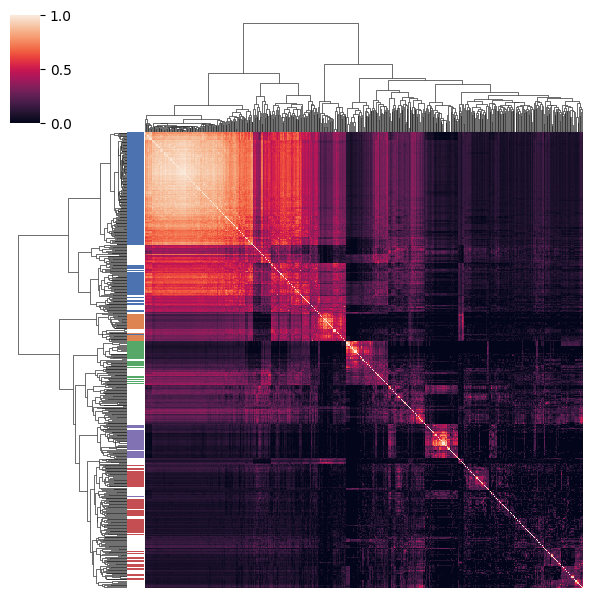

In [7]:
min_cluster_size=15
labels = sklearn.cluster.HDBSCAN(min_cluster_size=min_cluster_size).fit_predict(1 - assoc_cmp)

print(f'got {numpy.unique(labels).max() + 1} labels')
palette = sns.color_palette('deep', numpy.unique(labels).max() + 1)
cluster_colors = [palette[x] if x >= 0 else (1.0, 1.0, 1.0) for x in labels]

fig = sns.clustermap(assoc_cmp, xticklabels=[], yticklabels=[], figsize=(6, 6), row_colors=cluster_colors) # pangenome_colors

### Display a t-SNE analysis of the points + clusters

In [8]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, perplexity=50) # play with: perplexity
tsne_coords = tsne.fit_transform(1 - assoc_cmp)

Text(0, 0.5, 'Dimension 2')

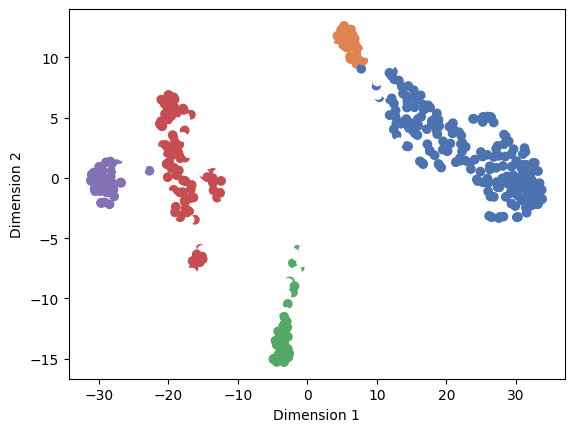

In [9]:
plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], color=cluster_colors)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

In [10]:
## ok, pull out the clusters
clusters_d = defaultdict(set)

for hashval, cluster_num in zip(assoc_hashvals, labels):
    if cluster_num >= 0:
        clusters_d[cluster_num].add(hashval)

print(f"Got {len(clusters_d)} clusters.")

Got 5 clusters.


In [11]:
for k, v in sorted(clusters_d.items(), key=lambda v: -len(v[1])):
    print(f"cluster {k} has size {len(v)}")

print(sum([ len(v) for v in clusters_d.values() ]), 'clustered, of', len(assoc_hashvals), 'total')

cluster 0 has size 197
cluster 3 has size 86
cluster 4 has size 41
cluster 2 has size 39
cluster 1 has size 29
392 clustered, of 608 total


## Plot a sample by hash presence matrix

got 91 samples for presence plot.
creating presence matrix: 91 x 608


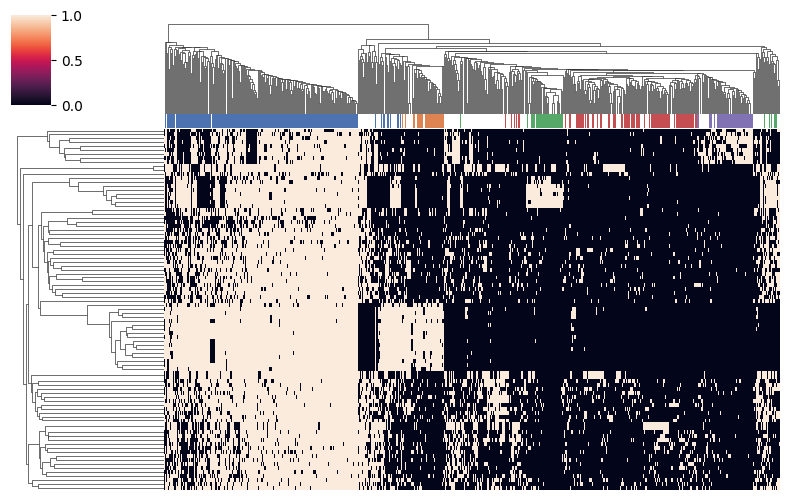

In [12]:
_, _, presence_mat = presence_info.build_presence_matrix()
sns.clustermap(presence_mat, xticklabels=[], yticklabels=[], figsize=(8, 5), col_colors=cluster_colors)